In [122]:
import pandas as pd
import json
import requests
import copy
import matplotlib.pyplot as plt
import xgboost as xgb
import numpy as np
import lightgbm as lgb
from sklearn.model_selection import KFold
from sklearn import model_selection, preprocessing, metrics
import seaborn as sns
import estateFunction
import time

In [2]:
import gc 
gc.collect()

31

In [3]:
###경제상황을 반영해주기 위해 각종 지수들을 넣어줌.

###공동주택 실거래 가격지수 아파트 
apartIndex=pd.read_csv("indexData/apartIndex.csv",encoding="cp949")
apartIndex=list((apartIndex.iloc[10].reset_index())[10])[2:]
###경기종합 선행 지수
economicIndex=pd.read_csv("indexData/economicPredictionIndex.csv",encoding="cp949")
economicIndex=list((economicIndex.iloc[10].reset_index()[10])[1:])
###생산자 물가 지수
produceIndex=pd.read_csv("indexData/produceIndex.csv",encoding="cp949")
produceIndex=list((produceIndex.iloc[10].reset_index()[10])[1:])
###소비자 물가 지수
spendIndex=pd.read_csv("indexData/spendIndex.csv",encoding="cp949")
spendIndex=list((spendIndex.iloc[10].reset_index()[10])[1:])

In [4]:
###2018/12데이터를 예측하므로 2018/11까지 있어야됨
###2018/12데이터에는 2018/11데이터넣음
###2010/01데이터에는 2009/12데이터넣음
def makeApartIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return apartIndex[index]
def makeEconomicIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return economicIndex[index]
def makeSpendIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return spendIndex[index]
def makeProduceIndex(x):
    index=(x-201001)//100*12+(x-201001)%100
    return produceIndex[index]

In [5]:
kfoldData=pd.read_csv("dataAfterPreprocess/finaltrain")  
kfoldTarget=kfoldData['거래금액(만원)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldData['거래금액(만원)']
del kfoldData['시군구']
del kfoldData['번지']
del kfoldData['본번']
del kfoldData['부번']
###object에서 category로 바꾸어주어야함
kfoldData['단지명']=kfoldData['단지명'].astype('category')
kfoldData['도로명']=kfoldData['도로명'].astype('category')
kfoldData['big']=kfoldData['big'].astype('category')
kfoldData['small']=kfoldData['small'].astype('category')

In [6]:
kfoldData['apartIndex']=kfoldData['계약년월'].apply(makeApartIndex).astype('float')
kfoldData['economicIndex']=kfoldData['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldData['spendIndex']=kfoldData['계약년월'].apply(makeSpendIndex).astype('float')
kfoldData['produceIndex']=kfoldData['계약년월'].apply(makeProduceIndex).astype('float')

In [7]:
kfoldTest=pd.read_csv("dataAfterPreprocess/finaltest")
testTarget=kfoldTest["거래금액(만원)"]/kfoldTest['전용면적(㎡)']
#target값 삭제해주고 나머지 변수들은 훈련에 사용될 수 없음
del kfoldTest['거래금액(만원)']
del kfoldTest['시군구']
del kfoldTest['번지']
del kfoldTest['본번']
del kfoldTest['부번']
del kfoldTest['공시가격']
del kfoldTest['공시가격(만원)']
###object에서 category로 바꾸어주어야함
kfoldTest['단지명']=kfoldTest['단지명'].astype('category')
kfoldTest['도로명']=kfoldTest['도로명'].astype('category')
kfoldTest['big']=kfoldTest['big'].astype('category')
kfoldTest['small']=kfoldTest['small'].astype('category')

In [8]:
kfoldTest['apartIndex']=kfoldTest['계약년월'].apply(makeApartIndex).astype('float')
kfoldTest['economicIndex']=kfoldTest['계약년월'].apply(makeEconomicIndex).astype('float')
kfoldTest['spendIndex']=kfoldTest['계약년월'].apply(makeSpendIndex).astype('float')
kfoldTest['produceIndex']=kfoldTest['계약년월'].apply(makeProduceIndex).astype('float')

In [9]:
kfoldData.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
kfoldTest.columns=['Apart name','USM','Sold date','Storey','Build year','Street name','latitude','longitude','District','dong',
                   'Sold month','Apart index','Leading index','Consumer index', 'Producer index']
###ppsm으로 고쳐줘야 되므로
kfoldTarget=kfoldTarget/kfoldData['USM']

In [10]:
len(kfoldData),len(kfoldTarget),len(kfoldTest),len(testTarget)

(554312, 554312, 1393, 1393)

In [11]:
SST=sum((testTarget-np.mean(testTarget))**2)

In [12]:
###big제외하고 원핫인코딩하기에는 너무 많다.
kfoldDataWithBig=copy.deepcopy(kfoldData)
kfoldTestWithBig=copy.deepcopy(kfoldTest)
del kfoldDataWithBig['Apart name']
del kfoldDataWithBig['Street name']
del kfoldDataWithBig['dong']
del kfoldTestWithBig['Apart name']
del kfoldTestWithBig['Street name']
del kfoldTestWithBig['dong']

In [13]:
cat_features = ['District'] 

for column in cat_features:
    temp = pd.get_dummies(pd.Series(kfoldDataWithBig[column])) 
    kfoldDataWithBig = pd.concat([kfoldDataWithBig,temp],axis=1) 
    kfoldDataWithBig = kfoldDataWithBig.drop([column],axis=1) 

for column in cat_features: 
    temp = pd.get_dummies(pd.Series(kfoldTestWithBig[column])) 
    kfoldTestWithBig = pd.concat([kfoldTestWithBig,temp],axis=1) 
    kfoldTestWithBig = kfoldTestWithBig.drop([column],axis=1)

In [14]:
%%time
#OLS
from sklearn.linear_model import LinearRegression
reg=LinearRegression()
reg.fit(kfoldDataWithBig,kfoldTarget)
olsPre=reg.predict(kfoldTestWithBig)
olsOof=reg.predict(kfoldDataWithBig)
reg.intercept_,reg.coef_

Wall time: 2.16 s


(-131192.15449393567,
 array([-1.16479458e+00,  7.77454988e-02,  5.84953234e+00,  1.18272560e+00,
         1.51192143e+03,  4.53427989e+02,  1.01912973e+00,  9.71996600e-01,
         2.50740539e+01, -4.72872807e+01,  1.57624570e+01,  6.09856443e+02,
        -4.78333598e+01, -3.08584535e+02, -3.66521102e+01,  1.40682899e+01,
         5.48852010e+01, -2.48995873e+01, -2.73540415e+01, -3.43446120e+02,
        -3.92116847e+02, -1.92632758e+02,  1.25412681e+02,  1.01796672e+02,
        -1.07887041e+02,  4.99537808e+02,  5.69988991e+01, -2.20765511e+02,
         2.65974723e+02,  1.18365738e+02,  7.92028254e+01,  3.00958412e+02,
        -1.87463938e+02, -3.57760689e+01,  5.11911551e+00, -3.06764890e+02]))

In [15]:
(abs(testTarget-olsPre)/testTarget*100).describe()

count    1393.000000
mean       18.668295
std        16.988034
min         0.014343
25%         6.556310
50%        14.655353
75%        25.470564
max       162.819954
dtype: float64

In [16]:
1-sum((testTarget-olsPre)**2)/SST

0.6481738097326828

In [17]:
%%time
###randomforest 단일모델
from sklearn.ensemble import RandomForestRegressor
rfOof = np.zeros(len(kfoldDataWithBig))
rfPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)

for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    print(n_fold)
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    ranFo=RandomForestRegressor(n_estimators=200, max_depth=50, n_jobs=-1)
    ranFo.fit(trn_x,trn_y)
    
    rfOof[val_idx]=ranFo.predict(val_x)
    rfPre+=ranFo.predict(kfoldTestWithBig)/folds.n_splits

0
1
2
3
4
Wall time: 24min 22s


In [21]:
(abs(testTarget-rfPre)/testTarget*100).describe()

count    1393.000000
mean        4.630240
std         5.797320
min         0.007272
25%         1.336847
50%         3.100083
75%         5.791577
max        73.931918
dtype: float64

In [26]:
1-sum((testTarget-rfPre)**2)/SST

0.970668692266536

In [ ]:
###xgboost 단일모델 
xgboost.train(params, dtrain, num_boost_round=10, 
              evals=(), obj=None, feval=None, maximize=False, early_stopping_rounds=None, 
              evals_result=None, verbose_eval=True, xgb_model=None, callbacks=None, learning_rates=None)
evals (list of pairs (DMatrix, string)) – List of validation sets for which metrics will evaluated during training. 
Validation metrics will help us track the performance of the model.

In [46]:
%%time
###범주형 변수 big만 남겼음
###속도가 빨라짐
xgbOof = np.zeros(len(kfoldDataWithBig))
xgbPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(kfoldDataWithBig,kfoldTarget)) : 
    trn_x, trn_y = kfoldDataWithBig.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = kfoldDataWithBig.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 11,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(kfoldTestWithBig) 
    xgbPre += model_xgb.predict(test_data) / folds.n_splits 
    xgbOof[val_idx] = model_xgb.predict(va_data)

[12:45:47] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:581.047	valid-mae:581.987
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:33.5115	valid-mae:37.0338
[200]	train-mae:27.5186	valid-mae:32.2746
[300]	train-mae:24.3802	valid-mae:30.0896
[400]	train-mae:22.2283	valid-mae:28.7695
[500]	train-mae:20.5777	valid-mae:27.9005
[600]	train-mae:19.3611	valid-mae:27.3474
[700]	train-mae:18.2583	valid-mae:26.8767
[800]	train-mae:17.3057	valid-mae:26.5219
[900]	train-mae:16.4909	valid-mae:26.2684
[1000]	train-mae:15.737	valid-mae:26.0739
[1100]	train-mae:15.0532	valid-mae:25.9151
[1200]	train-mae:14.3738	valid-mae:25.7849
[1300]	train-mae:13.8007	valid-mae:25.6891
[1400]	train-mae:13.2192	valid-mae:25.6085
[1500]	train-mae:12.7038	valid-mae:25.5495
[1600]	train-mae:

In [47]:
(abs(testTarget-xgbPre)/testTarget*100).describe()

count    1393.000000
mean        3.980424
std         5.250533
min         0.000224
25%         1.279435
50%         2.775165
75%         5.040847
max       101.525927
dtype: float64

In [48]:
1-sum((testTarget-xgbPre)**2)/SST

0.9808851311094067

In [49]:
###lightgbm 파라미터
param = {'num_leaves': 200,                 #default=31
         'min_data_in_leaf': 10,            #default=20
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.1,           ###트리만들때마다 0.01 씩 가중치 곱함
         "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
         "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
         "bagging_freq": 1,                 ###bagging 의빈도
         "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
         "bagging_seed": 11,              ###bagging 을 위한 seed
         "metric": 'mae',
         "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
         "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함

In [50]:
#lightgbm단일모델인데 범주형 변수 제외하고 이거는 가변수 쓰지말고 그냥 big 그대로 쓰자
lightgbmOof=np.zeros(len(kfoldDataWithBig))
lightgbmPre=np.zeros(len(kfoldTestWithBig))
kfoldData2=copy.deepcopy(kfoldData)
kfoldTest2=copy.deepcopy(kfoldTest)
del kfoldData2['Apart name']
del kfoldData2['Street name']
del kfoldData2['dong']
del kfoldTest2['Apart name']
del kfoldTest2['Street name']
del kfoldTest2['dong']

In [51]:
%%time
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df = pd.DataFrame()
features=kfoldData2.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData2, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData2.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData2.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=300)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof[valid_idx] = clf.predict(kfoldData2.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre += clf.predict(kfoldTest2, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df = pd.DataFrame()
    fold_importance_df["feature"]=features
    fold_importance_df["importance"] = clf.feature_importance()
    fold_importance_df["order"] = order + 1
    
    feature_importance_df = pd.concat([feature_importance_df, fold_importance_df], axis=0)

-
Fold 1
Training until validation scores don't improve for 300 rounds
[100]	valid_0's l1: 44.5463
[200]	valid_0's l1: 37.7842
[300]	valid_0's l1: 34.9965
[400]	valid_0's l1: 32.9447
[500]	valid_0's l1: 31.6433
[600]	valid_0's l1: 30.7455
[700]	valid_0's l1: 30.0013
[800]	valid_0's l1: 29.4665
[900]	valid_0's l1: 28.9819
[1000]	valid_0's l1: 28.6513
[1100]	valid_0's l1: 28.3562
[1200]	valid_0's l1: 28.0985
[1300]	valid_0's l1: 27.8672
[1400]	valid_0's l1: 27.7118
[1500]	valid_0's l1: 27.5671
[1600]	valid_0's l1: 27.4591
[1700]	valid_0's l1: 27.3463
[1800]	valid_0's l1: 27.2584
[1900]	valid_0's l1: 27.1926
[2000]	valid_0's l1: 27.1301
[2100]	valid_0's l1: 27.0587
[2200]	valid_0's l1: 27.0021
[2300]	valid_0's l1: 26.9552
[2400]	valid_0's l1: 26.9107
[2500]	valid_0's l1: 26.8766
[2600]	valid_0's l1: 26.8342
[2700]	valid_0's l1: 26.795
[2800]	valid_0's l1: 26.7548
[2900]	valid_0's l1: 26.7286
[3000]	valid_0's l1: 26.7116
[3100]	valid_0's l1: 26.69
[3200]	valid_0's l1: 26.669
[3300]	valid_0

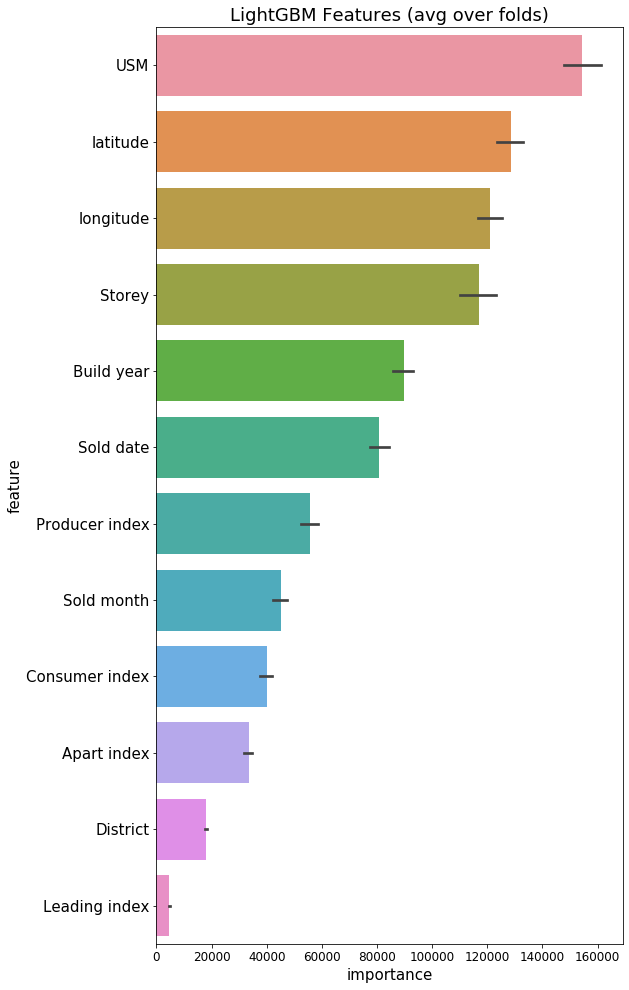

In [110]:
cols = (feature_importance_df[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:20].index)
###각변수들 평규내서 위에서 상위 1000개뽑는것 근디 총변수가 180개인데 의미있나?
best_features = feature_importance_df.loc[feature_importance_df.feature.isin(cols)]
                ###900개중에서 해당하는 변수가 중복으로 뽑히게됨 결과로 보니 그런듯
    ###그런데 그림으로 그릴때는 이게 합쳐지는듯
plt.figure(figsize=(9,14))
plt.rc('font',size=15)
plt.rc('xtick',labelsize=12)
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('big_lgbm_importances.png')

In [53]:
(abs(testTarget-lightgbmPre)/testTarget*100).describe()

count    1393.000000
mean        4.037011
std         5.169295
min         0.013181
25%         1.249797
50%         2.809651
75%         5.106928
max        88.367465
dtype: float64

In [54]:
1-sum((testTarget-lightgbmPre)**2)/SST

0.9799474887413544

In [55]:
%%time
###lightgbm 데이터 다쓰는것 범주형 다쓰는거임
lightgbmOof2=np.zeros(len(kfoldData))
lightgbmPre2=np.zeros(len(kfoldTest))
folds=KFold(n_splits=5,shuffle=True,random_state=15)
feature_importance_df2 = pd.DataFrame()
features2=kfoldData.columns
for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(kfoldData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(kfoldData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    lightgbmOof2[valid_idx] = clf.predict(kfoldData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    lightgbmPre2 += clf.predict(kfoldTest, num_iteration=clf.best_iteration) / folds.n_splits
    
    fold_importance_df2 = pd.DataFrame()
    fold_importance_df2["feature"]=features2
    fold_importance_df2["importance"] = clf.feature_importance()
    fold_importance_df2["order"] = order + 1
    
    feature_importance_df2 = pd.concat([feature_importance_df2, fold_importance_df2], axis=0)

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 28.9135
[200]	valid_0's l1: 27.506
[300]	valid_0's l1: 26.8481
[400]	valid_0's l1: 26.4643
[500]	valid_0's l1: 26.1934
[600]	valid_0's l1: 25.9629
[700]	valid_0's l1: 25.8315
[800]	valid_0's l1: 25.7125
[900]	valid_0's l1: 25.6285
[1000]	valid_0's l1: 25.5533
[1100]	valid_0's l1: 25.487
[1200]	valid_0's l1: 25.4371
[1300]	valid_0's l1: 25.4051
[1400]	valid_0's l1: 25.3625
[1500]	valid_0's l1: 25.3184
[1600]	valid_0's l1: 25.3018
[1700]	valid_0's l1: 25.2773
[1800]	valid_0's l1: 25.2545
[1900]	valid_0's l1: 25.2472
[2000]	valid_0's l1: 25.2378
[2100]	valid_0's l1: 25.2264
[2200]	valid_0's l1: 25.2218
[2300]	valid_0's l1: 25.2154
[2400]	valid_0's l1: 25.2148
Early stopping, best iteration is:
[2362]	valid_0's l1: 25.2132
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 28.8567
[200]	valid_0's l1: 27.3751
[300]	valid_0's l1: 26.7898
[400]	valid_0's l1: 26.42

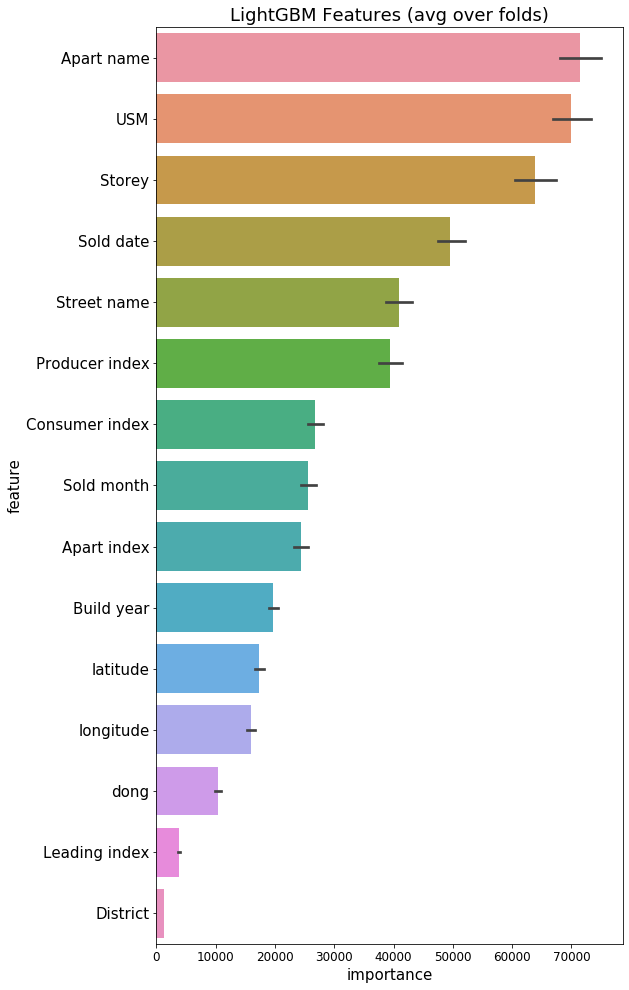

In [112]:
cols = (feature_importance_df2[["feature", "importance"]].groupby("feature").mean()
        .sort_values(by="importance", ascending=False)[:20].index)
###각변수들 평규내서 위에서 상위 1000개뽑는것 근디 총변수가 180개인데 의미있나?
best_features = feature_importance_df2.loc[feature_importance_df2.feature.isin(cols)]
                ###900개중에서 해당하는 변수가 중복으로 뽑히게됨 결과로 보니 그런듯
    ###그런데 그림으로 그릴때는 이게 합쳐지는듯
plt.figure(figsize=(9,14))
plt.rc('font',size=15)
plt.rc('xtick',labelsize=12)
sns.barplot(x="importance",
            y="feature",
            data=best_features.sort_values(by="importance",
                                           ascending=False))
plt.title('LightGBM Features (avg over folds)')
plt.tight_layout()
plt.savefig('all_lgbm_importances.png')

In [57]:
#lightgbm단일모델 범주형 다씀
(abs(testTarget-lightgbmPre2)/testTarget*100).describe()

count    1393.000000
mean        3.773415
std         4.620306
min         0.007808
25%         1.349899
50%         2.650733
75%         4.829539
max        90.467486
dtype: float64

In [58]:
1-sum((testTarget-lightgbmPre2)**2)/SST

0.9835394503223169

In [59]:
###단일로 stack model
lightgbmOof,xgbOof,rfOof,olsOof,lightgbmPre,xgbPre,rfPre,olsPre

(array([469.69553347, 247.50692795, 358.02750286, ..., 539.41302518,
        482.68145112, 530.2591245 ]),
 array([439.84936523, 297.4413147 , 348.57669067, ..., 447.8117981 ,
        524.08776855, 561.73095703]),
 array([405.48569649, 449.39650026, 533.54278473, ..., 508.1588795 ,
        542.31376984, 560.80482592]),
 array([673.22294932, 534.40934814, 620.56345739, ..., 777.52869278,
        802.78370286, 766.76955175]),
 array([498.9379271 , 559.41207097, 433.78184627, ..., 347.20512638,
        370.43438173, 377.37573054]),
 array([503.57687378, 555.86234283, 436.52948761, ..., 342.71218109,
        365.58908081, 376.29444885]),
 array([509.37953366, 573.39860728, 436.75295032, ..., 339.21071322,
        369.8860201 , 373.82242009]),
 array([703.5101574 , 696.06351859, 366.28710609, ..., 367.93326442,
        406.9195554 , 419.03186355]))

In [60]:
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof,"ols":olsOof})

In [61]:
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre,"ols":olsPre})

In [62]:
stackPre=np.zeros(len(kfoldTest))
stackOof=np.zeros(len(stackData))

In [63]:
%%time
print("xgboost") 
sOof = np.zeros(len(kfoldDataWithBig))
sPre = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(stackData,kfoldTarget)) : 
    trn_x, trn_y = stackData.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = stackData.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 10,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(stackTestData) 
    sPre += model_xgb.predict(test_data) / folds.n_splits 
    sOof[val_idx] = model_xgb.predict(va_data)

xgboost
[15:05:28] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.914	valid-mae:581.834
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.8288	valid-mae:24.975
[200]	train-mae:23.4167	valid-mae:25.039
[300]	train-mae:23.0464	valid-mae:25.0911
[400]	train-mae:22.6797	valid-mae:25.1448
[500]	train-mae:22.3554	valid-mae:25.1918
Stopping. Best iteration:
[79]	train-mae:23.9065	valid-mae:24.9691

[15:08:22] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:581.089	valid-mae:581.179
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.7

In [64]:
#stack단일모델 xgboost 이용 
(abs(testTarget-sPre)/testTarget*100).describe()

count    1393.000000
mean        3.969322
std         5.126947
min         0.001259
25%         1.287478
50%         2.713428
75%         5.032813
max        92.319986
dtype: float64

In [65]:
1-sum((testTarget-sPre)**2)/SST

0.9800546325772302

In [66]:
###lightgbm 파라미터
param = {'num_leaves': 200,                 #default=31
         'min_data_in_leaf': 10,            #default=20
         'objective':'regression',
         'max_depth': -1,
         'learning_rate': 0.01,           ###트리만들때마다 0.01 씩 가중치 곱함
         "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
         "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
         "bagging_freq": 1,                 ###bagging 의빈도
         "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
         "bagging_seed": 11,              ###bagging 을 위한 seed
         "metric": 'mae',
         "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
         "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함

In [67]:
%%time
for order, (train_idx,valid_idx) in enumerate(folds.split(stackData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(stackData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(stackData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    stackOof[valid_idx] = clf.predict(stackData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    stackPre += clf.predict(stackTestData, num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.6558
[200]	valid_0's l1: 39.6568
[300]	valid_0's l1: 27.9485
[400]	valid_0's l1: 25.9385
[500]	valid_0's l1: 25.6673
[600]	valid_0's l1: 25.6418
[700]	valid_0's l1: 25.6507
Early stopping, best iteration is:
[609]	valid_0's l1: 25.6416
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 84.9091
[200]	valid_0's l1: 39.3638
[300]	valid_0's l1: 27.7808
[400]	valid_0's l1: 25.8225
[500]	valid_0's l1: 25.5654
[600]	valid_0's l1: 25.5486
Early stopping, best iteration is:
[569]	valid_0's l1: 25.5465
-
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.065
[200]	valid_0's l1: 39.4501
[300]	valid_0's l1: 27.938
[400]	valid_0's l1: 26.0069
[500]	valid_0's l1: 25.7699
[600]	valid_0's l1: 25.7624
Early stopping, best iteration is:
[556]	valid_0's l1: 25.7578
-
Fold 4
Training until validation scores don't improve for 100 roun

In [68]:
#stack단일모델 
(abs(testTarget-stackPre)/testTarget*100).describe()

count    1393.000000
mean        3.988636
std         5.164848
min         0.001177
25%         1.274562
50%         2.740715
75%         5.009222
max        91.427134
dtype: float64

In [69]:
1-sum((testTarget-stackPre)**2)/SST

0.9786395124002212

In [114]:
%%time
###OLS 빼고 stack 인데 XGBoost
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof})
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre})
print("xgboost") 
sOof3 = np.zeros(len(kfoldDataWithBig))
sPre3 = np.zeros(len(kfoldTestWithBig)) 
folds=KFold(n_splits=5,shuffle=True,random_state=15)
for n_fold, (trn_idx, val_idx) in enumerate(folds.split(stackData,kfoldTarget)) : 
    trn_x, trn_y = stackData.iloc[trn_idx], kfoldTarget[trn_idx] 
    val_x, val_y = stackData.iloc[val_idx], kfoldTarget[val_idx] 
    params = {'objective': 'reg:linear', 
              'booster':'gbtree',                   ###Tree base 모델
              'eval_metric': 'mae', 
              'eta': 0.1,           ###학습속도 일반적으로 0.01~0.2
              'max_depth': 10,    ###트리 최대깊이 일반적으로 3~10
              'subsample': 0.9,    ###각 트리마다 관측 데이터 샘플링 비율 0.5~1
              'colsample_bytree': 0.9,   ###각 트리마다 변수 샘플링 비율 0.5~1
              'alpha':0.001,                    ###규제항 
              'random_state': 42, 
              'verbosity': 1}                ###동작메시지 출력
    tr_data = xgb.DMatrix(trn_x, trn_y) 
    va_data = xgb.DMatrix(val_x, val_y) 
    watchlist = [(tr_data, 'train'), (va_data, 'valid')] 
    model_xgb = xgb.train(params, tr_data, 10000, watchlist, maximize=False, early_stopping_rounds = 500, verbose_eval=100) 
    
    test_data = xgb.DMatrix(stackTestData) 
    sPre3 += model_xgb.predict(test_data) / folds.n_splits 
    sOof3[val_idx] = model_xgb.predict(va_data)

xgboost
[15:31:35] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:580.913	valid-mae:581.839
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:24.0149	valid-mae:25.0117
[200]	train-mae:23.6832	valid-mae:25.0619
[300]	train-mae:23.3849	valid-mae:25.1053
[400]	train-mae:23.0954	valid-mae:25.1513
[500]	train-mae:22.8118	valid-mae:25.1998
Stopping. Best iteration:
[80]	train-mae:24.083	valid-mae:25.0037

[15:34:17] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[0]	train-mae:581.087	valid-mae:581.174
Multiple eval metrics have been passed: 'valid-mae' will be used for early stopping.

Will train until valid-mae hasn't improved in 500 rounds.
[100]	train-mae:23.

In [116]:
#stack단일모델 
(abs(testTarget-sPre3)/testTarget*100).describe()

count    1393.000000
mean        3.986502
std         5.111710
min         0.003558
25%         1.256764
50%         2.748055
75%         5.049641
max        89.382633
dtype: float64

In [117]:
1-sum((testTarget-sPre3)**2)/SST

0.9796936720001292

In [118]:
%%time
###OLS 빼고 stack 인데 lightgbm
stackData=pd.DataFrame({"rf":rfOof, "xgb":xgbOof, "light":lightgbmOof})
stackTestData=pd.DataFrame({"rf":rfPre, "xgb":xgbPre, "light":lightgbmPre})
stackPre3=np.zeros(len(kfoldTest))
stackOof3=np.zeros(len(stackData))
for order, (train_idx,valid_idx) in enumerate(folds.split(stackData, kfoldTarget)):
    print('-')
    print("Fold {}".format(order + 1))
    trn_data = lgb.Dataset(stackData.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
    val_data = lgb.Dataset(stackData.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

    num_round = 10000          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
    ###early는 100번동안 효과없으면 그만둠
    
    clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=100)
    #훈련해서 모수가 조정된 모델에 valid 데이터 넣어서 예측값 보여주는것
    stackOof3[valid_idx] = clf.predict(stackData.iloc[valid_idx], num_iteration=clf.best_iteration)
    ###5개모델 다더해서 나누면 최종 예측치 되는것
    stackPre3 += clf.predict(stackTestData, num_iteration=clf.best_iteration) / folds.n_splits

-
Fold 1
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.6252
[200]	valid_0's l1: 39.6478
[300]	valid_0's l1: 27.9794
[400]	valid_0's l1: 26.0018
[500]	valid_0's l1: 25.7405
[600]	valid_0's l1: 25.7189
Early stopping, best iteration is:
[580]	valid_0's l1: 25.7185
-
Fold 2
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 84.8974
[200]	valid_0's l1: 39.3758
[300]	valid_0's l1: 27.8191
[400]	valid_0's l1: 25.8711
[500]	valid_0's l1: 25.6218
[600]	valid_0's l1: 25.6043
Early stopping, best iteration is:
[575]	valid_0's l1: 25.6035
-
Fold 3
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.0724
[200]	valid_0's l1: 39.4286
[300]	valid_0's l1: 27.9143
[400]	valid_0's l1: 25.9823
[500]	valid_0's l1: 25.7481
[600]	valid_0's l1: 25.7385
Early stopping, best iteration is:
[558]	valid_0's l1: 25.7359
-
Fold 4
Training until validation scores don't improve for 100 rounds
[100]	valid_0's l1: 85.

In [119]:
#stack단일모델 
(abs(testTarget-stackPre3)/testTarget*100).describe()

count    1393.000000
mean        4.006625
std         5.180879
min         0.005063
25%         1.272375
50%         2.761728
75%         5.042760
max        92.178886
dtype: float64

In [120]:
1-sum((testTarget-stackPre3)**2)/SST

0.979021095370455

In [153]:
numlist=[10,50,100,200,500,1000,1500,2000,5000,10000,15000]
timelist=[]
scorelist=[]

In [154]:
for i in numlist:
    ###lightgbm 파라미터
    param = {'num_leaves': 200,                 #default=31  ->이걸로 하이퍼 파라미터 조정하면될듯.
             'min_data_in_leaf': 10,            #default=20
             'objective':'regression',
             'max_depth': -1,
             'learning_rate': 0.1,           ###트리만들때마다 0.01 씩 가중치 곱함
             "boosting": "gbdt",                ###워래 우리가 아는 gbdt 씀
             "feature_fraction": 0.9,          ###변수 90%만 쓰게됨
             "bagging_freq": 1,                 ###bagging 의빈도
             "bagging_fraction": 0.9,        ###데이터를 90%만 쓰게됨 resampling 없이
             "bagging_seed": 11,              ###bagging 을 위한 seed
             "metric": 'mae',
             "lambda_l1": 0.1,                  ###오메가 항에서 람다 말할는거임 가중치 옆에 붙는 weights 숫자가 클수록 보수적
             "verbosity": -1}                      ###보수적이라는말은 트리생성을 잘안할려고함
    #lightgbm단일모델인데 범주형 변수 제외하고 이거는 가변수 쓰지말고 그냥 big 그대로 쓰자
   
    lightgbmPre5=np.zeros(len(kfoldTestWithBig))
    kfoldData2=copy.deepcopy(kfoldData)
    kfoldTest2=copy.deepcopy(kfoldTest)
    del kfoldData2['Apart name']
    del kfoldData2['Street name']
    del kfoldData2['dong']
    del kfoldTest2['Apart name']
    del kfoldTest2['Street name']
    del kfoldTest2['dong']
    
    start=time.time()

    folds=KFold(n_splits=5,shuffle=True,random_state=15)
   
    for order, (train_idx,valid_idx) in enumerate(folds.split(kfoldData2, kfoldTarget)):
        print('-')
        print("Fold {}".format(order + 1))
        trn_data = lgb.Dataset(kfoldData2.iloc[train_idx], label=kfoldTarget.iloc[train_idx])
        val_data = lgb.Dataset(kfoldData2.iloc[valid_idx], label=kfoldTarget.iloc[valid_idx])

        num_round = i          ###boosting 10000번 한다는소리임 verbose_eval 은 100번마다 출력함
        ###early는 100번동안 효과없으면 그만둠
    
        clf = lgb.train(param, trn_data, num_round, valid_sets = [val_data], verbose_eval=100, early_stopping_rounds=20000)
       
        ###5개모델 다더해서 나누면 최종 예측치 되는것
        lightgbmPre5 += clf.predict(kfoldTest2, num_iteration=clf.best_iteration) / folds.n_splits

    
    timelist.append(time.time()-start)
    scorelist.append((abs(testTarget-lightgbmPre5)/testTarget*100).describe())
    scorelist.append(1-sum((testTarget-lightgbmPre5)**2)/SST)
    
    if i==300:
        break

-
Fold 1
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 114.093
-
Fold 2
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.618
-
Fold 3
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.719
-
Fold 4
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 114.335
-
Fold 5
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[10]	valid_0's l1: 113.329
-
Fold 1
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iteration is:
[50]	valid_0's l1: 55.374
-
Fold 2
Training until validation scores don't improve for 20000 rounds
Did not meet early stopping. Best iterat

[200]	valid_0's l1: 37.4454
[300]	valid_0's l1: 34.6791
[400]	valid_0's l1: 32.865
[500]	valid_0's l1: 31.5644
[600]	valid_0's l1: 30.7152
[700]	valid_0's l1: 29.9678
[800]	valid_0's l1: 29.383
[900]	valid_0's l1: 29.0137
[4300]	valid_0's l1: 26.5766
[4400]	valid_0's l1: 26.5819
[4500]	valid_0's l1: 26.5808
[4600]	valid_0's l1: 26.5819
[4700]	valid_0's l1: 26.579
[4800]	valid_0's l1: 26.5823
[4900]	valid_0's l1: 26.5883
[5000]	valid_0's l1: 26.5891
[5100]	valid_0's l1: 26.5953
[5200]	valid_0's l1: 26.5977
[5300]	valid_0's l1: 26.5954
[5400]	valid_0's l1: 26.5974
[5500]	valid_0's l1: 26.6018
[5600]	valid_0's l1: 26.6056
[5700]	valid_0's l1: 26.6094
[5800]	valid_0's l1: 26.6137
[5900]	valid_0's l1: 26.6155
[6000]	valid_0's l1: 26.6235
[6100]	valid_0's l1: 26.6265
[6200]	valid_0's l1: 26.6312
[6300]	valid_0's l1: 26.6389
[6400]	valid_0's l1: 26.6442
[6500]	valid_0's l1: 26.647
[6600]	valid_0's l1: 26.6513
[6700]	valid_0's l1: 26.6549
[6800]	valid_0's l1: 26.663
[6900]	valid_0's l1: 26.669

[6400]	valid_0's l1: 26.7385
[6500]	valid_0's l1: 26.7446
[6600]	valid_0's l1: 26.7475
[6700]	valid_0's l1: 26.7536
[6800]	valid_0's l1: 26.7606
[6900]	valid_0's l1: 26.7679
[7000]	valid_0's l1: 26.7749
[7100]	valid_0's l1: 26.7829
[7200]	valid_0's l1: 26.7869
[7300]	valid_0's l1: 26.7951
[7400]	valid_0's l1: 26.7992
[7500]	valid_0's l1: 26.8058
[7600]	valid_0's l1: 26.8112
[7700]	valid_0's l1: 26.8195
[7800]	valid_0's l1: 26.8269
[7900]	valid_0's l1: 26.8344
[8000]	valid_0's l1: 26.8422
[8100]	valid_0's l1: 26.8487
[8200]	valid_0's l1: 26.8562
[8300]	valid_0's l1: 26.8631
[8400]	valid_0's l1: 26.8698
[8500]	valid_0's l1: 26.8763
[8600]	valid_0's l1: 26.8827
[8700]	valid_0's l1: 26.8875
[8800]	valid_0's l1: 26.8969
[8900]	valid_0's l1: 26.902
[9000]	valid_0's l1: 26.9088
[9100]	valid_0's l1: 26.9135
[9200]	valid_0's l1: 26.9209
[9300]	valid_0's l1: 26.9269
[9400]	valid_0's l1: 26.9344
[9500]	valid_0's l1: 26.9386
[9600]	valid_0's l1: 26.9463
[9700]	valid_0's l1: 26.9527
[9800]	valid_0'

[13700]	valid_0's l1: 27.0623
[13800]	valid_0's l1: 27.0692
[13900]	valid_0's l1: 27.0744
[14000]	valid_0's l1: 27.0812
[14100]	valid_0's l1: 27.085
[14200]	valid_0's l1: 27.0904
[14300]	valid_0's l1: 27.0958
[14400]	valid_0's l1: 27.0991
[14500]	valid_0's l1: 27.1047
[14600]	valid_0's l1: 27.1096
[14700]	valid_0's l1: 27.1144
[14800]	valid_0's l1: 27.1202
[14900]	valid_0's l1: 27.1245
[15000]	valid_0's l1: 27.1283
Did not meet early stopping. Best iteration is:
[4300]	valid_0's l1: 26.5766
-
Fold 2
Training until validation scores don't improve for 20000 rounds
[100]	valid_0's l1: 44.121
[200]	valid_0's l1: 37.7511
[300]	valid_0's l1: 34.6516
[400]	valid_0's l1: 32.8181
[500]	valid_0's l1: 31.5147
[600]	valid_0's l1: 30.6539
[2800]	valid_0's l1: 26.6826
[2900]	valid_0's l1: 26.6547
[3000]	valid_0's l1: 26.6356
[3100]	valid_0's l1: 26.6226
[3200]	valid_0's l1: 26.6091
[3300]	valid_0's l1: 26.5971
[3400]	valid_0's l1: 26.5832
[3500]	valid_0's l1: 26.5799
[3600]	valid_0's l1: 26.5658
[37

[2800]	valid_0's l1: 26.8607
[2900]	valid_0's l1: 26.8362
[3000]	valid_0's l1: 26.8093
[3100]	valid_0's l1: 26.7853
[3200]	valid_0's l1: 26.7739
[3300]	valid_0's l1: 26.767
[3400]	valid_0's l1: 26.7545
[3500]	valid_0's l1: 26.7443
[3600]	valid_0's l1: 26.7343
[3700]	valid_0's l1: 26.722
[3800]	valid_0's l1: 26.7128
[3900]	valid_0's l1: 26.7123
[4000]	valid_0's l1: 26.7084
[4100]	valid_0's l1: 26.7064
[4200]	valid_0's l1: 26.6974
[4300]	valid_0's l1: 26.6934
[4400]	valid_0's l1: 26.6954
[4500]	valid_0's l1: 26.6921
[4600]	valid_0's l1: 26.6941
[4700]	valid_0's l1: 26.6926
[4800]	valid_0's l1: 26.6934
[4900]	valid_0's l1: 26.6966
[5000]	valid_0's l1: 26.6994
[5100]	valid_0's l1: 26.7036
[5200]	valid_0's l1: 26.7029
[5300]	valid_0's l1: 26.7033
[5400]	valid_0's l1: 26.7019
[5500]	valid_0's l1: 26.707
[5600]	valid_0's l1: 26.7128
[5700]	valid_0's l1: 26.7178
[5800]	valid_0's l1: 26.7194
[5900]	valid_0's l1: 26.7258
[6000]	valid_0's l1: 26.7246
[6100]	valid_0's l1: 26.7292
[6200]	valid_0's 

In [155]:
timelist

[5.545828342437744,
 14.192154884338379,
 19.02916431427002,
 29.675028085708618,
 57.73697876930237,
 109.4812080860138,
 158.20669269561768,
 207.498060464859,
 459.7498691082001,
 931.0199265480042,
 1385.9102156162262]

In [156]:
scorelist

[count    1393.000000
 mean       18.816469
 std        15.327715
 min         0.055774
 25%         7.694216
 50%        15.459403
 75%        25.838612
 max       132.546972
 dtype: float64, 0.70406771606019, count    1393.000000
 mean        8.748340
 std         8.849736
 min         0.000046
 25%         2.859233
 50%         6.362466
 75%        12.139643
 max        84.615789
 dtype: float64, 0.919205775595728, count    1393.000000
 mean        7.054915
 std         7.502068
 min         0.009010
 25%         2.319413
 50%         5.215110
 75%         9.393563
 max        81.130375
 dtype: float64, 0.9454355003898255, count    1393.000000
 mean        6.047685
 std         6.658537
 min         0.001011
 25%         2.133382
 50%         4.383300
 75%         7.831977
 max        90.791935
 dtype: float64, 0.9603340717129477, count    1393.000000
 mean        4.977538
 std         5.772808
 min         0.001465
 25%         1.760174
 50%         3.535911
 75%         6.397265
 